<a href="https://colab.research.google.com/github/Yarosuravu/Yarosuravu/blob/main/RF_5c_CO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



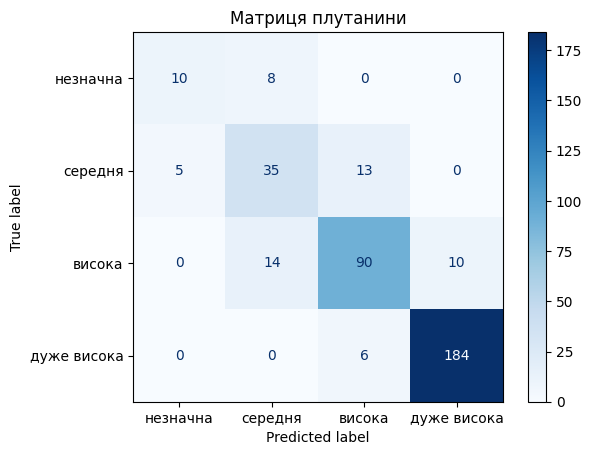

/tmp/ipython-input-7-781364521.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


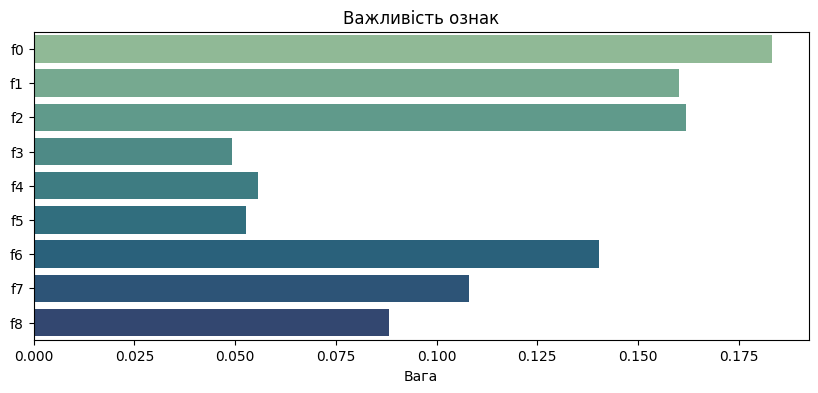

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()


Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



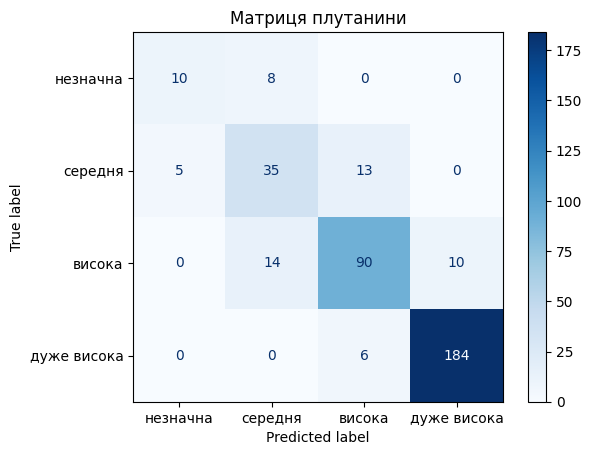

/tmp/ipython-input-10-238759180.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


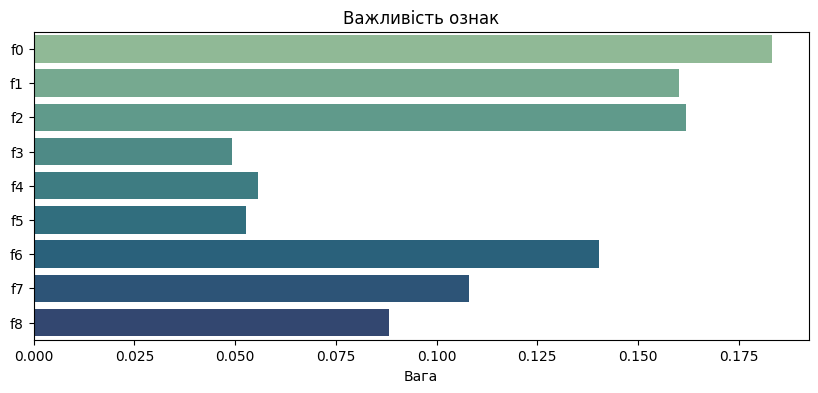

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 8. ROC-криві для багатокласової класифікації ---
# Бінаризація міток
n_classes = 5
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Побудова всіх кривих
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



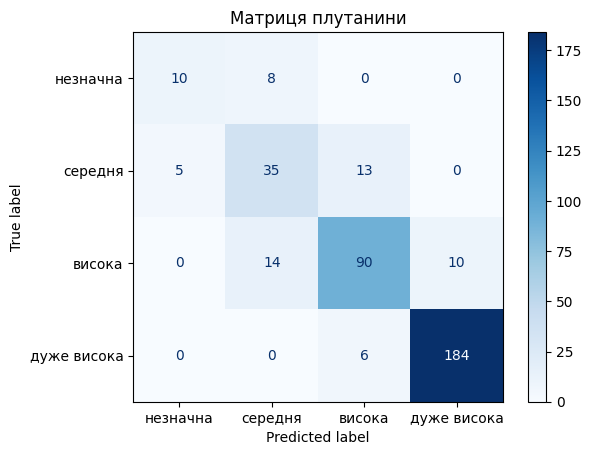

/tmp/ipython-input-11-3556101285.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


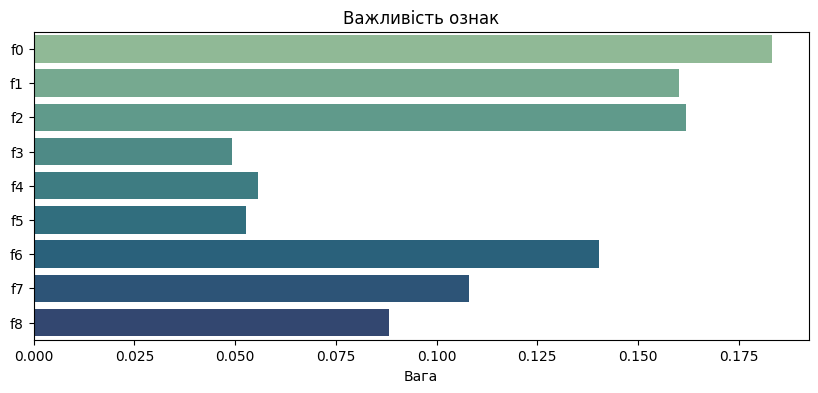

IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 8. ROC-криві для багатокласової класифікації ---
# Бінаризація міток для фактично присутніх класів
present_classes = np.unique(np.concatenate((y_test, y_pred)))
y_test_bin = label_binarize(y_test, classes=present_classes)
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_idx in enumerate(present_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, class_idx])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Побудова всіх кривих
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(range(len(present_classes)), colors):
    class_label = present_classes[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {class_label} ({class_names[class_label]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



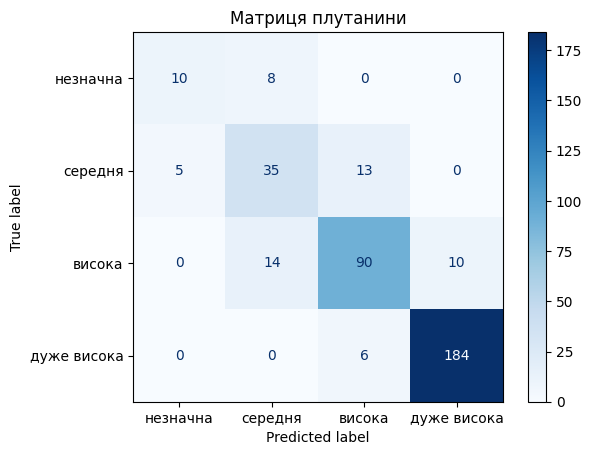

/tmp/ipython-input-12-1534152509.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


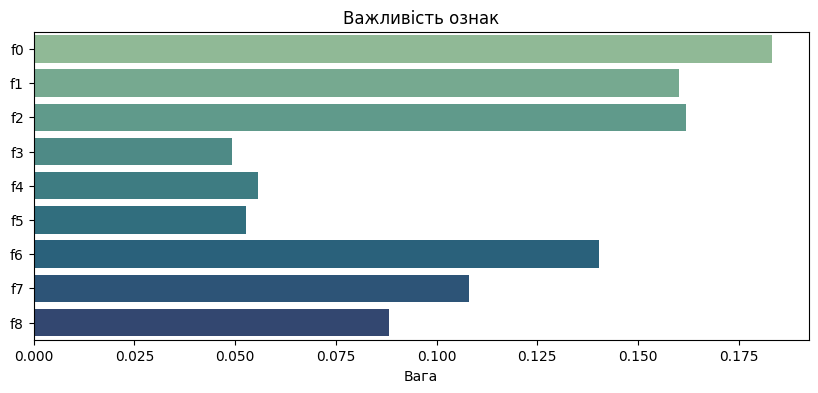

ValueError: could not broadcast input array from shape (4,) into shape (375,)

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 8. ROC-криві для багатокласової класифікації ---
# Фіксована кількість класів для побудови ймовірностей
n_classes = 5
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_score = model.predict_proba(X_test)

# y_score — список масивів по кожному класу
# перетворимо на масив [n_samples, n_classes] вручну
from numpy import zeros
proba_matrix = zeros((len(X_test), n_classes))
for class_index, class_proba in zip(model.classes_, y_score):
    proba_matrix[:, class_index] = class_proba[:, 1] if len(class_proba.shape) == 2 else class_proba

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        continue  # пропускаємо класи, які відсутні в y_test
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Побудова всіх кривих
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(roc_auc.keys(), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



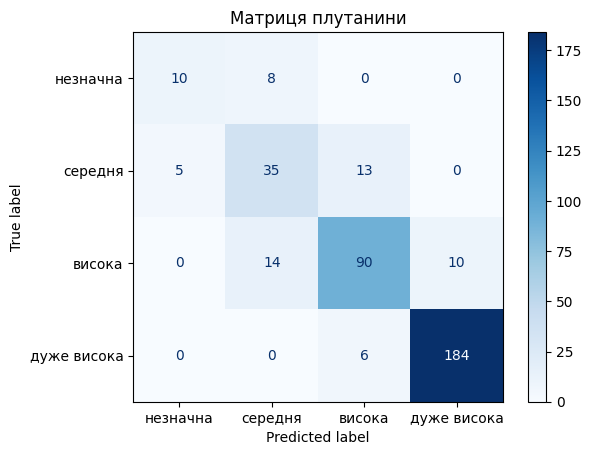

/tmp/ipython-input-14-4064464137.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


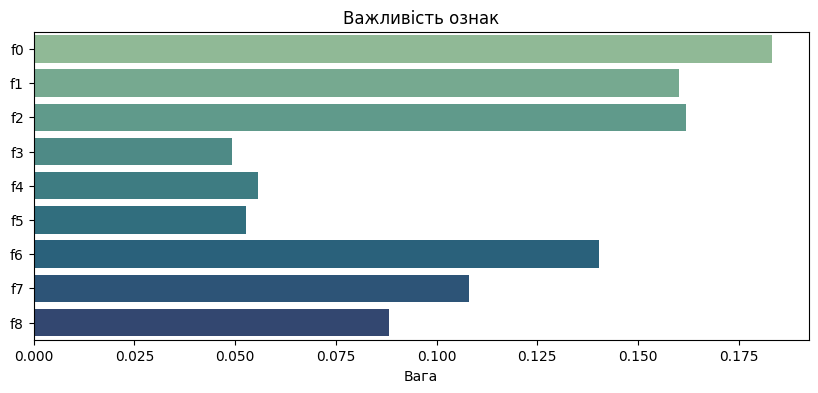

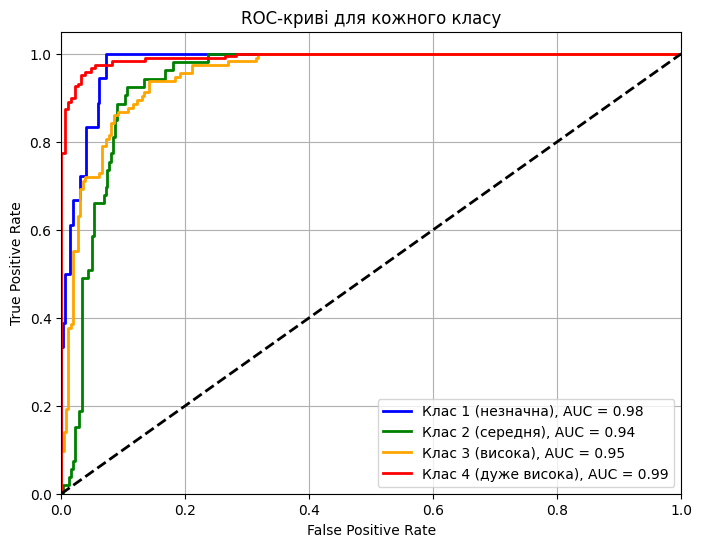

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 8. ROC-криві для багатокласової класифікації ---
# Фіксована кількість класів для побудови ймовірностей
n_classes = 5
# Бінаризація для всіх класів
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
# Отримуємо матрицю ймовірностей [n_samples, n_present_classes]
y_score_partial = model.predict_proba(X_test)
# Створюємо повну матрицю ймовірностей з нулями
proba_matrix = np.zeros((len(X_test), n_classes))
# Заповнюємо стовпці відповідно до model.classes_
for idx, cls in enumerate(model.classes_):
    proba_matrix[:, cls] = y_score_partial[:, idx]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Пропускаємо класи, яких нема в y_test
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Побудова всіх кривих
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(sorted(roc_auc.keys()), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           1      0.667     0.556     0.606        18
           2      0.614     0.660     0.636        53
           3      0.826     0.789     0.807       114
           4      0.948     0.968     0.958       190

    accuracy                          0.851       375
   macro avg      0.764     0.743     0.752       375
weighted avg      0.850     0.851     0.850       375



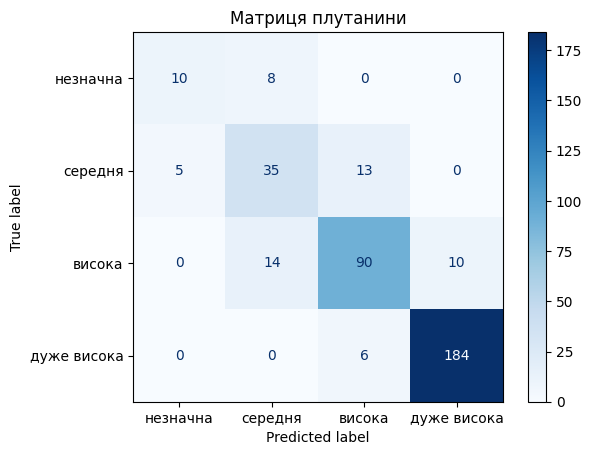

/tmp/ipython-input-15-3626331006.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


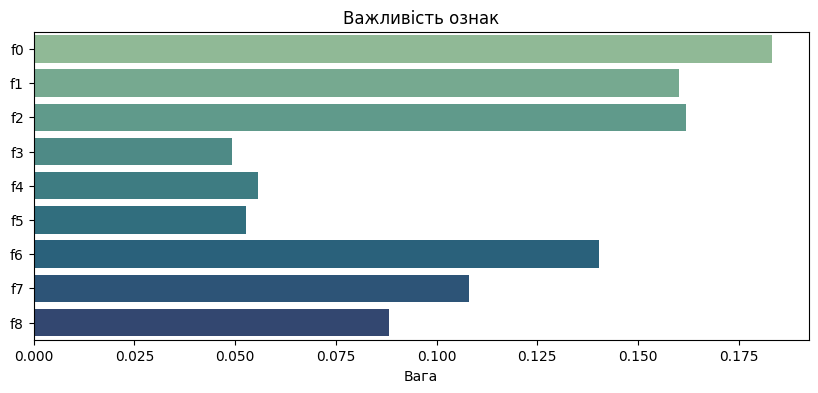

Macro-average AUC: 0.967
Micro-average AUC: 0.978


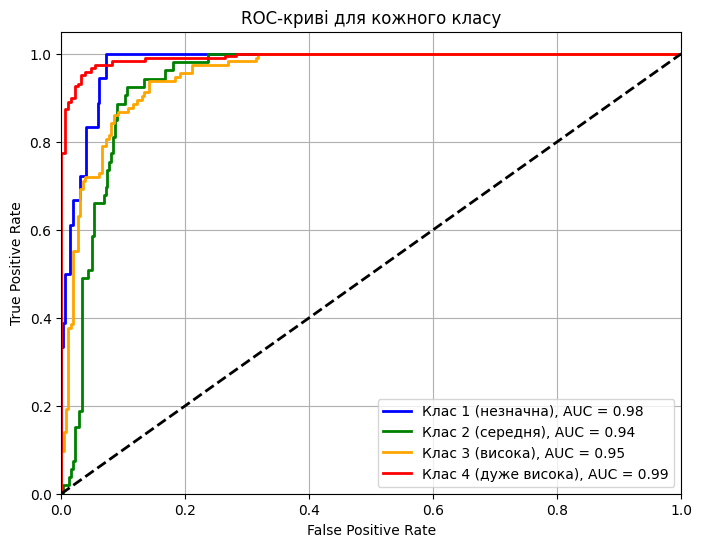

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Генерація синтетичних даних ---
np.random.seed(42)
N = 1500  # кількість зразків

# Генеруємо концентрацію CO в ppm (від 0 до 200)
co_ppm = np.random.uniform(0, 200, N)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
# Чим більше CO, тим менше I_sample (більше поглинання)
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.02, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)  # уникаємо ділення на 0
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Формування класів ---
# Класифікація за концентрацією CO
def ppm_to_class(ppm):
    if ppm <= 0.5: return 0  # немає
    elif ppm <= 9: return 1  # незначна
    elif ppm <= 35: return 2  # середня
    elif ppm <= 100: return 3  # висока
    else: return 4  # дуже висока

y = np.array([ppm_to_class(p) for p in co_ppm])

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 5. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 6. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 7. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 8. ROC-криві для багатокласової класифікації ---
# Фіксована кількість класів для побудови ймовірностей
n_classes = 5
# Бінаризація для всіх класів
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
# Отримуємо матрицю ймовірностей [n_samples, n_present_classes]
y_score_partial = model.predict_proba(X_test)
# Створюємо повну матрицю ймовірностей з нулями
proba_matrix = np.zeros((len(X_test), n_classes))
# Заповнюємо стовпці відповідно до model.classes_
for idx, cls in enumerate(model.classes_):
    proba_matrix[:, cls] = y_score_partial[:, idx]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Пропускаємо класи, яких нема в y_test
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Обчислення macro та micro AUC
# Враховуються тільки наявні класи
from sklearn.metrics import roc_auc_score
present_classes = [i for i in range(n_classes) if np.sum(y_test_bin[:, i]) > 0]
y_test_bin_present = y_test_bin[:, present_classes]
proba_matrix_present = proba_matrix[:, present_classes]

macro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='macro')
micro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='micro')

print(f"Macro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {micro_auc:.3f}")

# Побудова всіх кривих
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(sorted(roc_auc.keys()), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           0      0.605     0.707     0.652       225
           1      0.531     0.489     0.509       225
           2      0.820     0.751     0.784       225
           3      0.932     0.911     0.921       225
           4      0.961     0.978     0.969       225

    accuracy                          0.767      1125
   macro avg      0.770     0.767     0.767      1125
weighted avg      0.770     0.767     0.767      1125



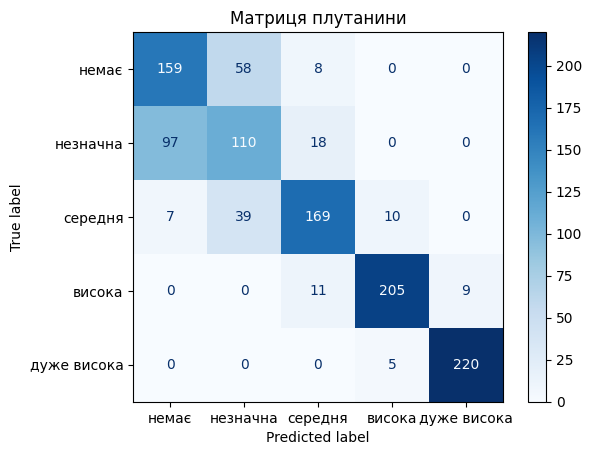

/tmp/ipython-input-18-3607998173.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


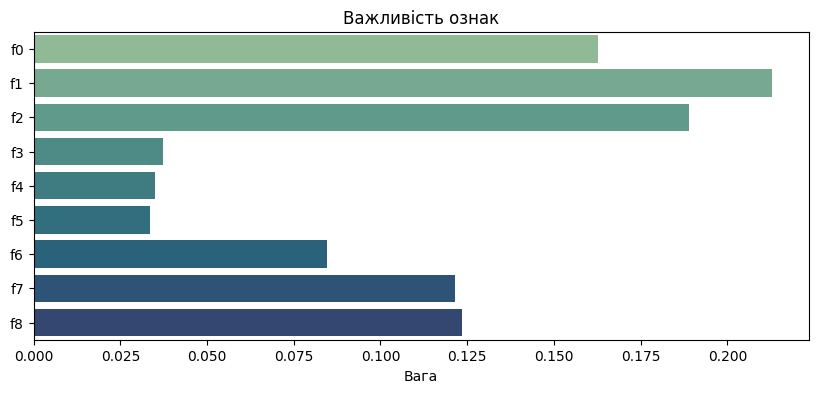

Macro-average AUC: 0.949
Micro-average AUC: 0.965


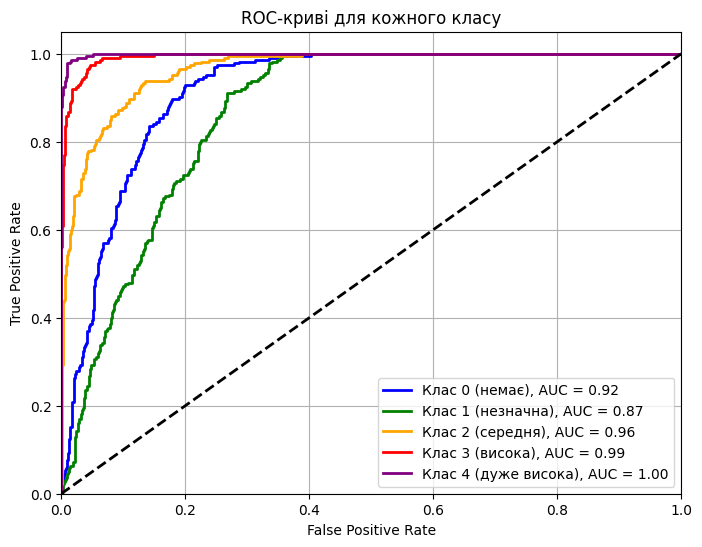

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- 1. Генерація синтетичних даних з контрольованим розподілом класів ---
np.random.seed(42)
n_samples_per_class = 900

# Генеруємо по 300 зразків для кожного класу вручну
ppm_classes = {
    0: np.random.uniform(0.0, 0.5, n_samples_per_class),
    1: np.random.uniform(0.6, 9.0, n_samples_per_class),
    2: np.random.uniform(9.1, 35.0, n_samples_per_class),
    3: np.random.uniform(35.1, 100.0, n_samples_per_class),
    4: np.random.uniform(100.1, 200.0, n_samples_per_class),
}

co_ppm = np.concatenate(list(ppm_classes.values()))
y = np.concatenate([[label]*n_samples_per_class for label in ppm_classes])
N = len(co_ppm)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.01, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 4. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 5. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця плутанини")
plt.show()

# --- 6. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 7. ROC-криві ---
n_classes = 5
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_score_partial = model.predict_proba(X_test)
proba_matrix = np.zeros((len(X_test), n_classes))
for idx, cls in enumerate(model.classes_):
    proba_matrix[:, cls] = y_score_partial[:, idx]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

from sklearn.metrics import roc_auc_score
present_classes = [i for i in range(n_classes) if np.sum(y_test_bin[:, i]) > 0]
y_test_bin_present = y_test_bin[:, present_classes]
proba_matrix_present = proba_matrix[:, present_classes]

macro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='macro')
micro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='micro')

print(f"Macro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {micro_auc:.3f}")

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(sorted(roc_auc.keys()), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification report:
              precision    recall  f1-score   support

           0      0.803     0.924     0.860       225
           1      0.873     0.764     0.815       225
           2      0.982     0.960     0.971       225
           3      0.987     0.982     0.984       225
           4      0.991     0.991     0.991       225

    accuracy                          0.924      1125
   macro avg      0.927     0.924     0.924      1125
weighted avg      0.927     0.924     0.924      1125



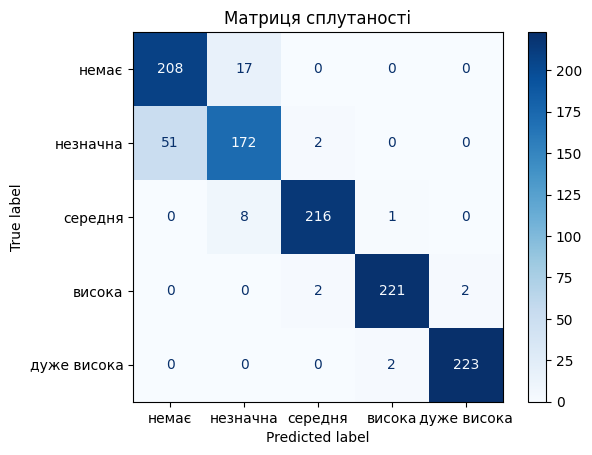

/tmp/ipython-input-23-3300197302.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


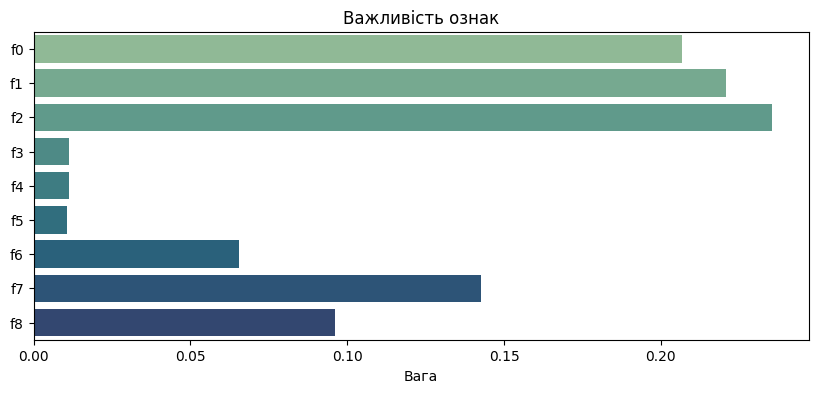

Macro-average AUC: 0.991
Micro-average AUC: 0.995


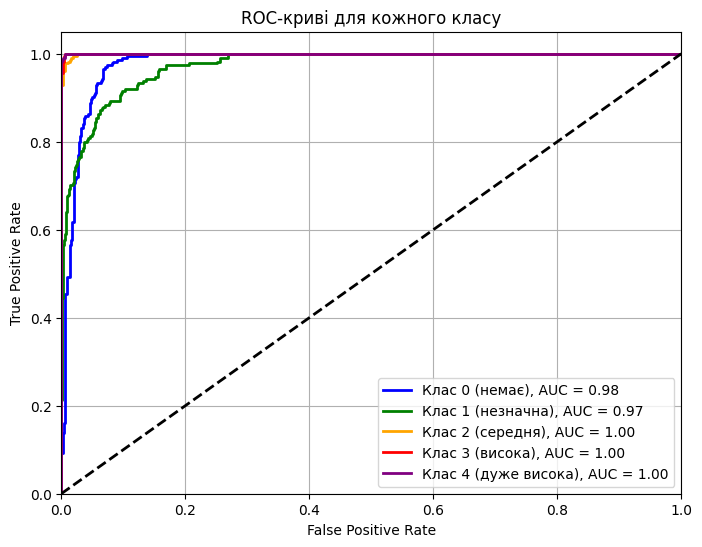

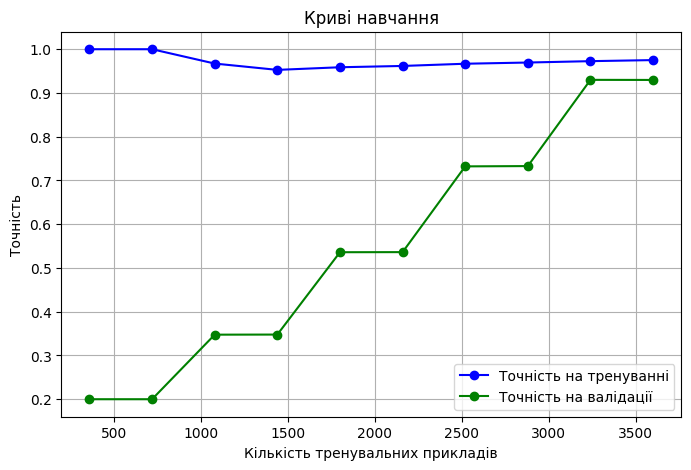

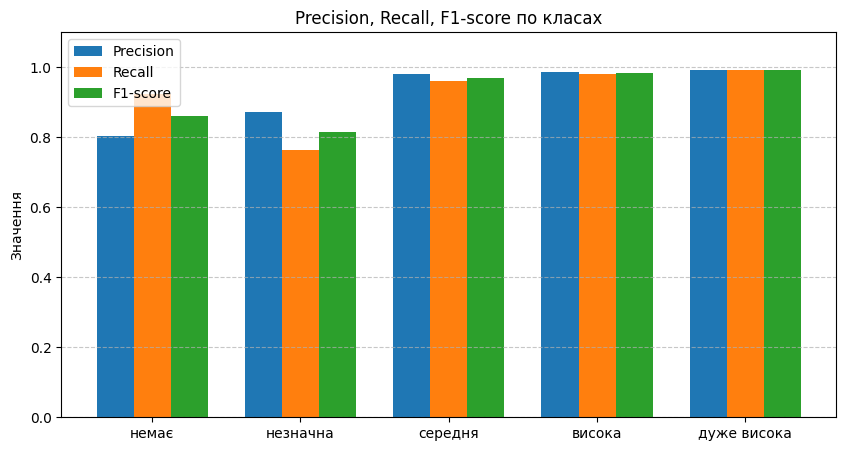

In [ ]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- 1. Генерація синтетичних даних з контрольованим розподілом класів ---
np.random.seed(42)
n_samples_per_class = 900

# Генеруємо по 300 зразків для кожного класу вручну
ppm_classes = {
    0: np.random.uniform(0.0, 0.5, n_samples_per_class),
    1: np.random.uniform(0.6, 9.0, n_samples_per_class),
    2: np.random.uniform(9.1, 35.0, n_samples_per_class),
    3: np.random.uniform(35.1, 100.0, n_samples_per_class),
    4: np.random.uniform(100.1, 200.0, n_samples_per_class),
}

co_ppm = np.concatenate(list(ppm_classes.values()))
y = np.concatenate([[label]*n_samples_per_class for label in ppm_classes])
N = len(co_ppm)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))  # для 3 сенсорів

# Симуляція I_ref (еталонного газу): більше поглинання, ніж у чистого повітря
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))

# Симуляція I_sample в залежності від концентрації CO
absorption = (co_ppm / 200).reshape(-1, 1)  # нормалізований вплив
noise = np.random.normal(loc=0, scale=0.002, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 4. Навчання моделі Random Forest ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 5. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in unique_labels])
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця сплутаності")
plt.show()

# --- 6. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- 7. ROC-криві ---
n_classes = 5
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_score_partial = model.predict_proba(X_test)
proba_matrix = np.zeros((len(X_test), n_classes))
for idx, cls in enumerate(model.classes_):
    proba_matrix[:, cls] = y_score_partial[:, idx]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

from sklearn.metrics import roc_auc_score
present_classes = [i for i in range(n_classes) if np.sum(y_test_bin[:, i]) > 0]
y_test_bin_present = y_test_bin[:, present_classes]
proba_matrix_present = proba_matrix[:, present_classes]

macro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='macro')
micro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='micro')

print(f"Macro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {micro_auc:.3f}")

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(sorted(roc_auc.keys()), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Криві навчання ---
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Точність на тренуванні')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Точність на валідації')
plt.title('Криві навчання')
plt.xlabel('Кількість тренувальних прикладів')
plt.ylabel('Точність')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- 9. Precision, Recall, F1 для кожного класу ---
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=range(n_classes))

x = np.arange(n_classes)
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, class_names)
plt.ylabel('Значення')
plt.title('Precision, Recall, F1-score по класах')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


Classification report:
              precision    recall  f1-score   support

           0      0.803     0.924     0.860       225
           1      0.873     0.764     0.815       225
           2      0.982     0.960     0.971       225
           3      0.987     0.982     0.984       225
           4      0.991     0.991     0.991       225

    accuracy                          0.924      1125
   macro avg      0.927     0.924     0.924      1125
weighted avg      0.927     0.924     0.924      1125



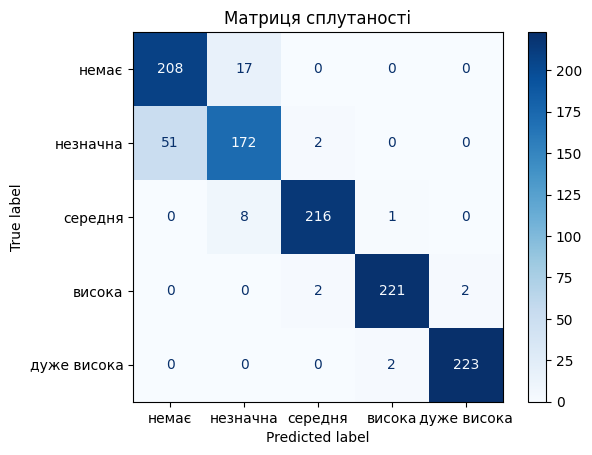

/tmp/ipython-input-3-904448831.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='crest')


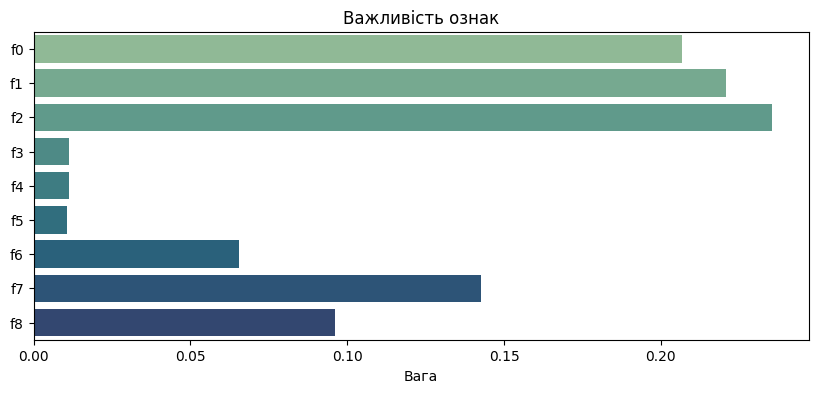

Macro-average AUC: 0.991
Micro-average AUC: 0.995


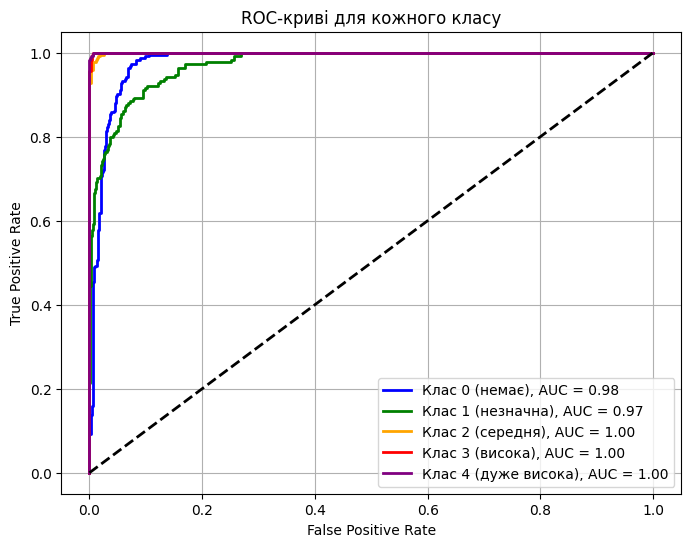

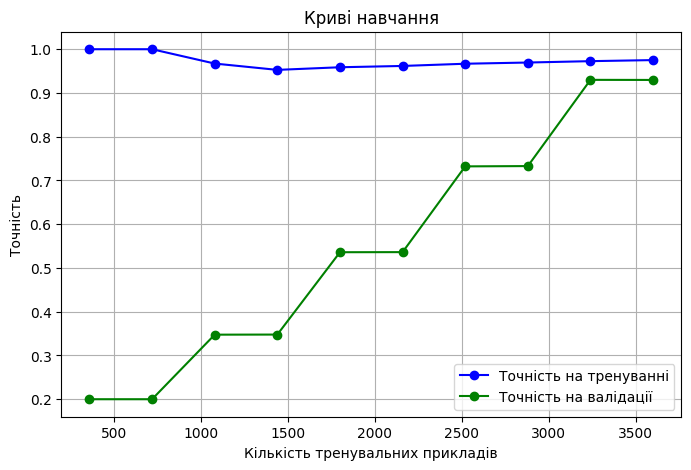

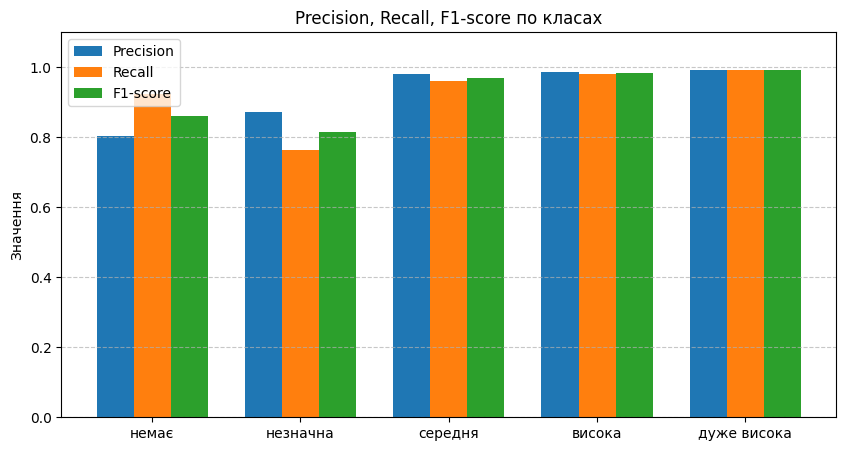

In [3]:
# !pip install scikit-learn matplotlib seaborn  # Розкоментуйте, якщо запуск у свіжому Colab

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# --- 1. Генерація синтетичних даних з контрольованим розподілом класів ---
np.random.seed(42)
n_samples_per_class = 900

# Генеруємо по 900 зразків для кожного класу вручну
ppm_classes = {
    0: np.random.uniform(0.0, 0.5, n_samples_per_class),
    1: np.random.uniform(0.6, 9.0, n_samples_per_class),
    2: np.random.uniform(9.1, 35.0, n_samples_per_class),
    3: np.random.uniform(35.1, 100.0, n_samples_per_class),
    4: np.random.uniform(100.1, 200.0, n_samples_per_class),
}

co_ppm = np.concatenate(list(ppm_classes.values()))
y = np.concatenate([[label]*n_samples_per_class for label in ppm_classes])
N = len(co_ppm)

# Симуляція I_air (довільна стала інтенсивність)
I_air = np.random.normal(loc=1.0, scale=0.05, size=(N, 3))
I_ref = I_air - np.random.normal(loc=0.2, scale=0.02, size=(N, 3))
absorption = (co_ppm / 200).reshape(-1, 1)
noise = np.random.normal(loc=0, scale=0.002, size=(N, 3))
I_sample = I_air - absorption * (I_air - I_ref) + noise

# --- 2. Розрахунок ознак ---
def compute_features(I_air, I_ref, I_sample):
    f1 = (I_air - I_sample) / (I_ref - I_air + 1e-6)
    f2 = (I_sample - I_ref) / (I_ref + 1e-6)
    f3 = I_sample / (I_air + 1e-6)
    return np.concatenate([f1, f2, f3], axis=1)

X = compute_features(I_air, I_ref, I_sample)

# --- Збереження вхідних даних ---
os.makedirs("output", exist_ok=True)
pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])]).assign(label=y).to_csv("output/features_labels.csv", index=False)

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --- 4. Навчання моделі ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- 5. Оцінка якості ---
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
class_names = ["немає", "незначна", "середня", "висока", "дуже висока"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Матриця сплутаності")
plt.show()

# --- Збереження прогнозів ---
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).to_csv("output/test_predictions.csv", index=False)

# --- 6. Важливість ознак ---
importances = model.feature_importances_
feat_names = [f'f{i}' for i in range(X.shape[1])]
plt.figure(figsize=(10, 4))
sns.barplot(x=importances, y=feat_names, palette='crest')
plt.title('Важливість ознак')
plt.xlabel('Вага')
plt.show()

# --- Збереження важливості ознак ---
pd.DataFrame({"feature": feat_names, "importance": importances}).to_csv("output/feature_importance.csv", index=False)

# --- 7. ROC-криві ---
n_classes = 5
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_score_partial = model.predict_proba(X_test)
proba_matrix = np.zeros((len(X_test), n_classes))
for idx, cls in enumerate(model.classes_):
    proba_matrix[:, cls] = y_score_partial[:, idx]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

present_classes = [i for i in range(n_classes) if np.sum(y_test_bin[:, i]) > 0]
y_test_bin_present = y_test_bin[:, present_classes]
proba_matrix_present = proba_matrix[:, present_classes]

macro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='macro')
micro_auc = roc_auc_score(y_test_bin_present, proba_matrix_present, average='micro')

print(f"Macro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {micro_auc:.3f}")

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, color in zip(sorted(roc_auc.keys()), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Клас {i} ({class_names[i]}), AUC = {roc_auc[i]:0.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-криві для кожного класу')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Криві навчання ---
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Точність на тренуванні')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Точність на валідації')
plt.title('Криві навчання')
plt.xlabel('Кількість тренувальних прикладів')
plt.ylabel('Точність')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- 9. Precision, Recall, F1 по класах ---
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=range(n_classes))

x = np.arange(n_classes)
width = 0.25
plt.figure(figsize=(10, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, class_names)
plt.ylabel('Значення')
plt.title('Precision, Recall, F1-score по класах')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Збереження метрик у CSV ---
pd.DataFrame({
    "class": class_names,
    "precision": prec,
    "recall": rec,
    "f1_score": f1
}).to_csv("output/class_metrics.csv", index=False)


In [4]:
import pandas as pd
import os

# Шлях до теки з файлами
data_dir = "output"

# Перевіримо, що тека існує
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Тека '{data_dir}' не знайдена. Запустіть код генерації та навчання моделі спочатку.")

# 1. Читання ознак та міток
features_df = pd.read_csv(os.path.join(data_dir, "features_labels.csv"))
print("🔹 Ознаки та мітки (features_labels.csv):")
print(features_df.head(), "\n")

# 2. Читання прогнозів моделі
predictions_df = pd.read_csv(os.path.join(data_dir, "test_predictions.csv"))
print("🔹 Прогнози моделі (test_predictions.csv):")
print(predictions_df.head(), "\n")

# 3. Читання важливості ознак
importance_df = pd.read_csv(os.path.join(data_dir, "feature_importance.csv"))
print("🔹 Важливість ознак (feature_importance.csv):")
print(importance_df.sort_values(by='importance', ascending=False), "\n")

# 4. Читання метрик по класах
metrics_df = pd.read_csv(os.path.join(data_dir, "class_metrics.csv"))
print("🔹 Precision / Recall / F1-score по класах (class_metrics.csv):")
print(metrics_df, "\n")


🔹 Ознаки та мітки (features_labels.csv):
         f0        f1        f2        f3        f4        f5        f6  \
0  0.006193  0.013168 -0.004325  0.325255  0.205034  0.304156  1.001512   
1 -0.008246  0.002952  0.001265  0.311771  0.265164  0.239159  0.998027   
2  0.005165  0.020791 -0.000295  0.250958  0.248985  0.274015  1.001031   
3 -0.012780 -0.000794  0.001200  0.277856  0.270495  0.203698  0.997192   
4  0.014211 -0.002181 -0.004432  0.201342  0.280066  0.249071  1.002353   

         f7        f8  label  
0  1.002215  0.998987      0  
1  1.000616  1.000243      0  
2  1.004076  0.999936      0  
3  0.999830  1.000202      0  
4  0.999521  0.999112      0   

🔹 Прогнози моделі (test_predictions.csv):
   y_test  y_pred
0       1       1
1       4       4
2       4       4
3       2       2
4       0       0 

🔹 Важливість ознак (feature_importance.csv):
  feature  importance
2      f2    0.235346
1      f1    0.220675
0      f0    0.206647
7      f7    0.142538
8      f8    